# Extreme Simplicity Bias (SB): MNIST-CIFAR Data
Recall that we define extreme simplicity bias (SB) as the tendency of neural networks trained with SGD or variants to learn a small-margin classifier that exclusively relies on the simplest feature and remain invariant to all complex features. In this notebook, we demonstrate the extreme nature of SB on the MNIST-CIFAR dataset, which is described in Section 3,3 of the [paper](https://arxiv.org/abs/2006.07710). We validate this phenomenon using the randomized metrics defined in Section 3.

In [71]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from imports import *
from cifar10_models import cifar10_models as c10

DEVICE_ID = 0 # GPU_ID or None (CPU)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load and visualize MNIST-CIFAR data

In [72]:
# load standard, MNIST-randomized, CIFAR-randomized datasets
mnist_classes = (0, 1)
cifar_classes = (1, 9)
batch_size = 256

tr_dl, te_dl = mc_utils.get_mnist_cifar_dl(mnist_classes=mnist_classes, cifar_classes=cifar_classes, bs=batch_size, 
                                           randomize_mnist=False, randomize_cifar=False)

trm_dl, tem_dl = mc_utils.get_mnist_cifar_dl(mnist_classes=mnist_classes, cifar_classes=cifar_classes, bs=batch_size, 
                                             randomize_mnist=True, randomize_cifar=False)

trc_dl, tec_dl = mc_utils.get_mnist_cifar_dl(mnist_classes=mnist_classes, cifar_classes=cifar_classes, bs=batch_size, 
                                             randomize_mnist=False, randomize_cifar=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


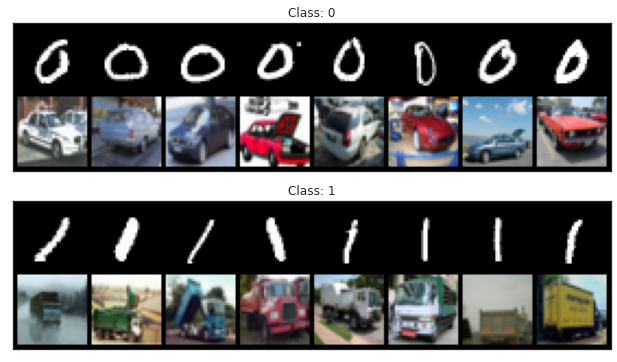

In [73]:
# visualize the standard dataset
_ = utils.visualize_loader_by_class(te_dl)
None

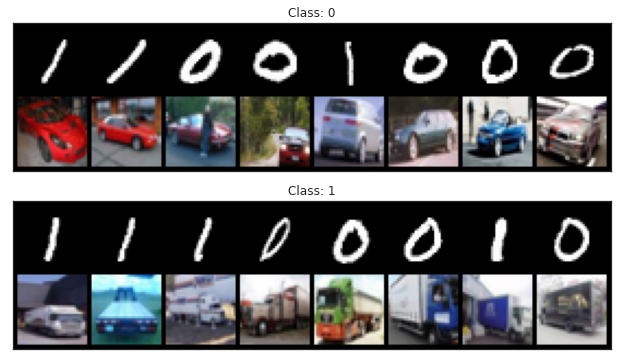

In [74]:
# visualize the MNIST-randomized dataset
_ = utils.visualize_loader_by_class(tem_dl)
None

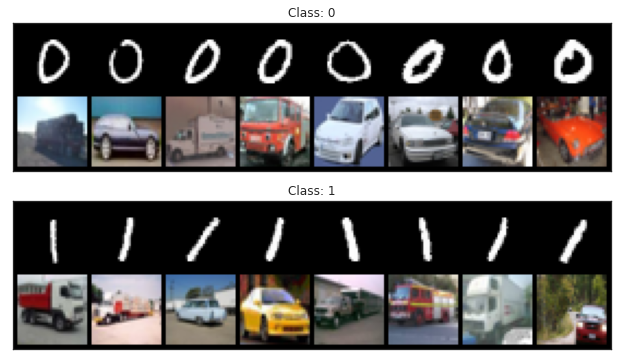

In [75]:
# visualize the CIFAR-randomized dataset
_ = utils.visualize_loader_by_class(tec_dl)
None

## Training a Resnet18 on MNIST-CIFAR data

In [76]:
CE = F.cross_entropy
device = gu.get_device(0) # change GPU device id here 

In [77]:
# Load ResNet and setup optimizer 
def lr_scheduler(epoch):
    if epoch < 30: return 1.0
    if 30 <= epoch: return 0.2
    
get_model = lambda: c10.resnet50(device=device, num_classes=2)
model = get_model().to(device)
opt = optim.SGD(model.parameters(), lr=0.05, weight_decay=5e-5)
sched = optim.lr_scheduler.LambdaLR(opt, lr_scheduler)

In [78]:
# train
stats = utils.fit_model(model, CE, opt, tr_dl, te_dl, device=device, sch=sched,
                        gap=50, patience_updates=1, is_loss_epsilon=True)

accuracy/loss measured every 50 updates
update_print_gap: 50, epss: 0.01, bs: 256, device: cuda:0
#updates, train acc, test acc, train loss
0 0.5043 0.5000 4.7069
50 0.9836 0.9893 0.0420
100 1.0000 0.9980 0.0004
converged after 2 epochs in 0.0m 29.305573s, gap: 0.002
init-ing patience (1 updates)
101 1.0000 0.9980 0.0004


Standard AUC: 1.000
MNIST-Randomized AUC: 0.494
CIFAR-Randomized AUC: 1.000


Text(0.5, 0.98, 'Logit Distributions of Positive Data')

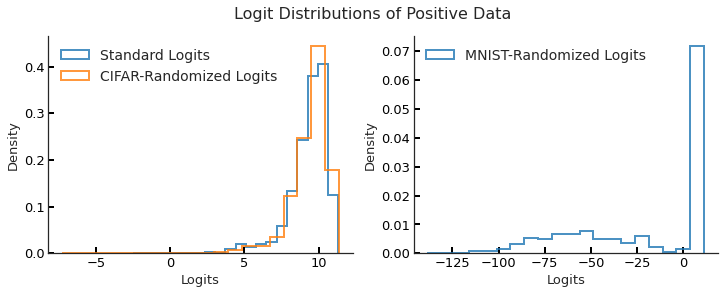

In [79]:
# Compute Standard, MNIST-Randomized and CIFAR-Randomized logits and AUCs

def get_logits(model, loader, device, label=1):
    X, Y = utils.extract_tensors_from_loader(loader)
    L = utils.get_logits_given_tensor(X, model, device=device).detach()
    L = L[Y==label].cpu().numpy()
    S = L[:, 1] - L[:, 0] # compute score / difference to get scalar 
    return S

SCP = {
    'std': get_logits(model, te_dl, device),
    'rand_mnist': get_logits(model, tem_dl, device),
    'rand_cifar': get_logits(model, tec_dl, device),
}

AUC = {
    'std': utils.get_binary_auc(model, te_dl, device),
    'rand_mnist': utils.get_binary_auc(model, tem_dl, device),
    'rand_cifar': utils.get_binary_auc(model, tec_dl,device),
}

print ("Standard AUC: {:.3f}".format(AUC['std']))
print ("MNIST-Randomized AUC: {:.3f}".format(AUC['rand_mnist']))
print ("CIFAR-Randomized AUC: {:.3f}".format(AUC['rand_cifar']))

# standard and randomized positive logit distributions
std_log, sc_log, s_log = SCP['std'], SCP['rand_cifar'], SCP['rand_mnist']

kw = dict(kde=False, bins=30, norm_hist=True, 
          hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.8, "ls": '-'})

# plot logit distributions
kw = dict(kde=False, bins=20, norm_hist=True, 
          hist_kws={"histtype": "step", "linewidth": 2, 
                    "alpha": 0.8, "ls": '-'})

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
sns.distplot(std_log, label='Standard Logits', ax=ax1, **kw)
sns.distplot(sc_log, label=r'CIFAR-Randomized Logits', ax=ax1, **kw)
sns.distplot(s_log, label=r'MNIST-Randomized Logits', ax=ax2, **kw)

utils.update_ax(ax1, '', 'Logits', 'Density', 
                ticks_fs=13, label_fs=13, title_fs=16, legend_fs=14, legend_loc='upper left')

utils.update_ax(ax2, '', 'Logits', 'Density', 
                ticks_fs=13, label_fs=13, title_fs=16, legend_fs=14, legend_loc='upper left')

fig.suptitle('Logit Distributions of Positive Data', fontsize=16)

As shown above, randomizing the MNIST block randomly shuffles the positive logits across both class and nullifies the predictive power of models learned via SGD; the AUC of the SGD-trained ResNet drops from $100\%$ to $50\%$ . On the other hand, randomzing the CIFAR (i.e., S^c) block has no effect on AUC or the logit distribution.